In [1]:
import seaborn as sns
import numpy as np
sns.set(color_codes=True)
from matplotlib import pyplot as plt
import torch
from torch import nn, optim

In [41]:
X_1 = np.random.normal(1, 1, 100)
X_2 = np.random.normal(1, 1, 100)
a_1 = 3
a_2 = 2
b_1 = -4
b_2 = 5
eps = np.random.normal(0, 1, 100)

In [42]:
Y_1 = a_1*X_1 + b_1 + eps

In [43]:
Y_2 = a_2*X_2 + b_2 + eps

Text(0, 0.5, 'Y')

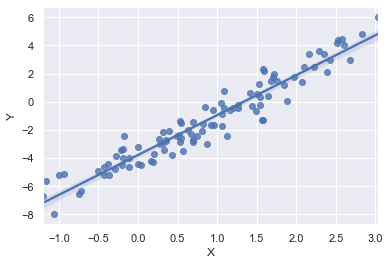

In [44]:
sns.regplot(X_1,Y_1)
plt.xlabel('X')
plt.ylabel('Y')

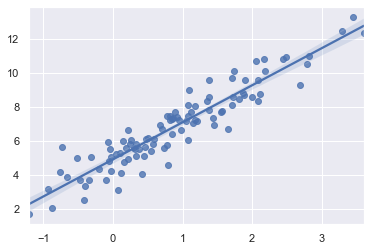

In [45]:
sns.regplot(X_2,Y_2)

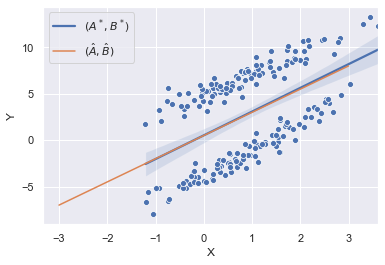

In [46]:
sns.scatterplot(np.concatenate((X_1, X_2)), np.concatenate((Y_1,Y_2)))
sns.regplot(np.concatenate((X_1, X_2)), np.concatenate((Y_1,Y_2)), label='$(A^*,B^*$)', scatter=False)
plt.plot([-3,3],[2.5*-3+0.5, 2.5*3+0.5], label='$(\hat{A},\hat{B})$')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

In [47]:
params = np.mgrid[-10:10:0.1,-10:10:0.1].T.reshape(-1,2)

In [48]:
y_1 = params[:,0].reshape(-1,1) @ X_1.reshape(1,-1) + params[:,1].reshape(-1,1)

In [49]:
loss_1 = np.sum((y_1 - Y_1) ** 2, axis=1) / len(Y_1)

Text(0, 0.5, 'beta')

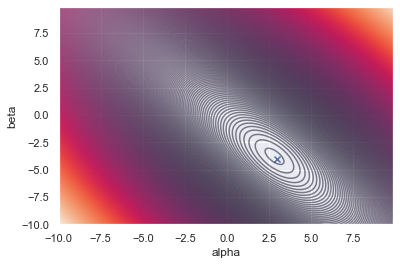

In [50]:
plt.contour(np.arange(-10,10,0.1), np.arange(-10,10,0.1), loss_1.reshape(200,200), levels=500, alpha=0.5)
plt.scatter([a_1],[b_1], marker='x')
plt.xlabel('alpha')
plt.ylabel('beta')

In [1959]:
y_2 = params[:,0].reshape(-1,1) @ X_2.reshape(1,-1) + params[:,1].reshape(-1,1)
loss_2 = np.sum((y_2 - Y_2) ** 2, axis=1) / len(Y_2)

Text(0, 0.5, 'beta')

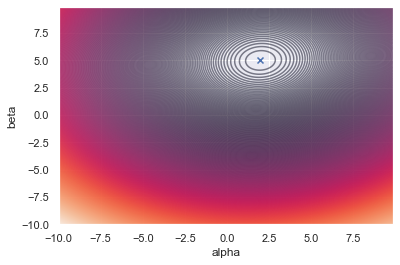

In [1960]:
plt.contour(np.arange(-10,10,0.1), np.arange(-10,10,0.1), loss_2.reshape(200,200), levels=500, alpha=0.5)
plt.scatter([a_2],[b_2], marker='x')
plt.xlabel('alpha')
plt.ylabel('beta')

Text(0, 0.5, 'beta')

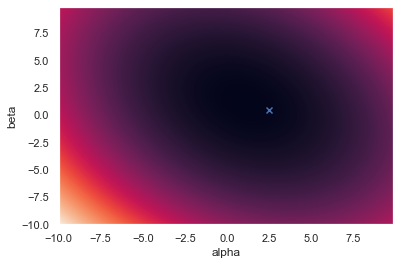

In [1961]:
plt.contourf(np.arange(-10,10,0.1), np.arange(-10,10,0.1), loss_1.reshape(200,200)  + loss_2.reshape(200,200), levels=500)
plt.scatter([(a_1 + a_2) / 2],[(b_1 + b_2) / 2], marker='x')
plt.xlabel('alpha')
plt.ylabel('beta')

In [1962]:
X_ = np.concatenate((X_1, X_2))
Y = np.concatenate((Y_1, Y_2))
X = np.ones((200, 2))
X[:,0] = X_
opt_params = (np.linalg.inv(X.T @ X)) @ (X.T @ Y)

In [1649]:
class LinearRegressor(nn.Module):
    def __init__(self):
        super(LinearRegressor, self).__init__()
        self.linear = nn.Linear(1, 1, bias=True)
        
    def forward(self, X):
        return self.linear(X)
    
    def __add__(self, other):
        my_copy = copy(self)
        with torch.no_grad():
            for self_param, other_param in zip(my_copy.parameters(), other.parameters()):
                self_param.data += other_param.data
        return my_copy

    def __truediv__(self, n):
        my_copy = copy(self)
        with torch.no_grad():
            for self_param in my_copy.parameters():
                self_param.data /= n
        return my_copy

    def zero(self):
        for self_param in self.parameters():
            self_param.data = torch.zeros_like(self_param.data)
        return self

In [1594]:
torch.manual_seed(0)

In [1652]:
X_1 = torch.tensor(X_1.reshape(-1, 1)).float()
X_2 = torch.tensor(X_2.reshape(-1, 1)).float()
Y_1 = torch.tensor(Y_1.reshape(-1, 1)).float()
Y_2 = torch.tensor(Y_2.reshape(-1, 1)).float()

In [1654]:
X = [X_1, X_2]
Y = [Y_1, Y_2]

In [1938]:
lr = 0.02
n_rounds = 100
n_steps = 1
loss_fn = nn.MSELoss()

In [1939]:
from copy import deepcopy as copy

In [1940]:
all_steps = [[[[] for _ in range(n_steps)] for _ in range(2)] for _ in range(n_rounds)]


server_model = LinearRegressor()
zero_model = LinearRegressor().zero()

for round in range(n_rounds):
    client_models = []
    for client in range(2):
        client_model = copy(server_model)
        optimizer = optim.SGD(lr=lr, params=client_model.parameters())
        for step in range(n_steps):
            optimizer.zero_grad()
        
            predict = client_model(X[client])
            loss = loss_fn(predict, Y[client])
            
            loss.backward()
            optimizer.step()
            
            for name, param in client_model.named_parameters():
                all_steps[round][client][step].extend(list(param.view(-1).detach().numpy()))
        client_models.append(client_model)
    
    server_model = sum(client_models, zero_model) / 2

In [1941]:
for opt_param, server_param in zip(opt_params, server_model.parameters()):
    print((opt_param - server_param.item()) ** 2)

0.003495200479587443
0.009580939224118663


In [1942]:
all_steps = np.array(all_steps)

Text(0, 0.5, 'beta')

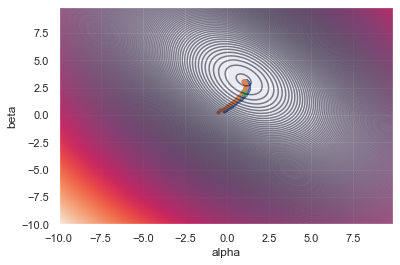

In [1943]:
for i in range(2):
    plt.scatter(all_steps[:,i,:,0].reshape(-1), all_steps[:,i,:,1].reshape(-1), marker='.')
plt.contour(np.arange(-10,10,0.1), np.arange(-10,10,0.1), loss_2.reshape(200,200) + loss_1.reshape(200,200), levels=500, alpha=0.5)
plt.scatter([(a_1 + a_2) / 2],[(b_1 + b_2) / 2], marker='x')
plt.xlabel('alpha')
plt.ylabel('beta')

Text(0, 0.5, 'beta')

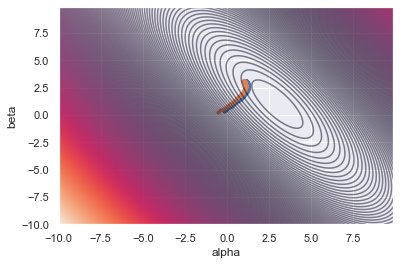

In [1944]:
for i in range(2):
    plt.scatter(all_steps[:,i,:,0].reshape(-1), all_steps[:,i,:,1].reshape(-1), marker='.')
plt.contour(np.arange(-10,10,0.1), np.arange(-10,10,0.1), loss_1.reshape(200,200), levels=500, alpha=0.5)
plt.xlabel('alpha')
plt.ylabel('beta')

Text(0, 0.5, 'beta')

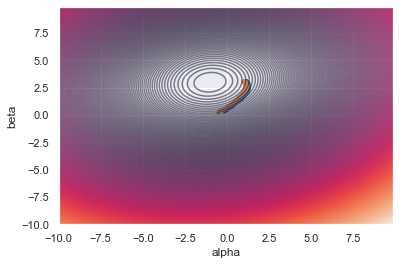

In [1945]:
for i in range(2):
    plt.scatter(all_steps[:,i,:,0].reshape(-1), all_steps[:,i,:,1].reshape(-1), marker='.')
plt.contour(np.arange(-10,10,0.1), np.arange(-10,10,0.1), loss_2.reshape(200,200), levels=500, alpha=0.5)
plt.xlabel('alpha')
plt.ylabel('beta')

In [1919]:
lr = 0.03
n_rounds = 100
max_steps = 50
distance_from_opt = np.zeros((max_steps, n_rounds))

zero_model = LinearRegressor().zero()

for i in range(1,max_steps):
    n_steps = i
    server_model = LinearRegressor()
    for round in range(n_rounds):
        client_models = []
        for client in range(2):
            client_model = copy(server_model)
            optimizer = optim.SGD(lr=lr, params=client_model.parameters())
            for step in range(n_steps):
                optimizer.zero_grad()

                predict = client_model(X[client])
                loss = loss_fn(predict, Y[client])

                loss.backward()
                optimizer.step()

            client_models.append(client_model)

        server_model = sum(client_models, zero_model) / 2
        distance = 0
        with torch.no_grad():
            for opt_param, server_param in zip(opt_params, server_model.parameters()):
                distance += (opt_param - server_param) ** 2
            distance_from_opt[n_steps-1][round] = distance

In [1920]:
distance_from_opt.shape

(50, 100)

## Lr = 0.03

/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


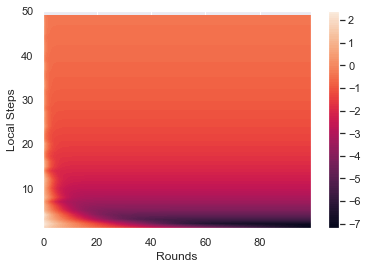

In [1921]:
plt.contourf(range(0, n_rounds), range(1,max_steps+1), np.log(distance_from_opt), levels=100)
plt.xlabel('Rounds')
plt.ylabel('Local Steps')
plt.colorbar()

## Lr = 0.01

/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


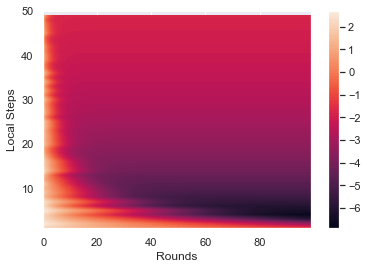

In [1902]:
plt.contourf(range(0, n_rounds), range(1,max_steps+1), np.log(distance_from_opt), levels=100)
plt.xlabel('Rounds')
plt.ylabel('Local Steps')
plt.colorbar()

## Lr = 0.001

/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


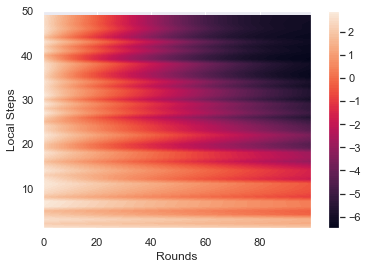

In [1904]:
plt.contourf(range(0, n_rounds), range(1,max_steps+1), np.log(distance_from_opt), levels=100)
plt.xlabel('Rounds')
plt.ylabel('Local Steps')
plt.colorbar()

# Single Variable

In [1963]:
def error(mean, std):
    X_1 = np.random.normal(0, 1, 1000)
    X_2 = np.random.normal(mean, std, 1000)
    
    a_1 = 3
    a_2 = 2
    b_1 = -4
    b_2 = 5
    Y_1 = a_1*X_1 + b_1
    Y_2 = a_2*X_2 + b_2

    X_ = np.concatenate((X_1, X_2))
    Y = np.concatenate((Y_1, Y_2))
    X = np.ones((2000, 2))
    X[:,0] = X_
    params = (np.linalg.inv(X.T @ X)) @ (X.T @ Y)

    return (params[0] - ((a_1 + a_2) / 2)) ** 2 + (params[1] - ((b_1 + b_2) / 2)) **2

In [1964]:
def kl(mu, sig):
    return np.log(1/sig) + (mu+1) / (2) - 0.5

## Varu 

In [591]:
xs = np.mgrid[-20:20:0.5, 0.1:20:0.1].T.reshape(-1,2)

def kl(X, Y):
    

Text(0, 0.5, '$ \\sigma_1$')

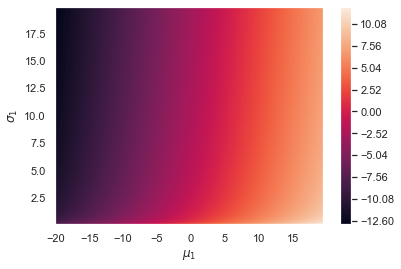

In [593]:
distances =  np.array(distances)
CS = plt.contourf(np.arange(-20,20,0.5), np.arange(0.1,20,0.1), distances.reshape(-1,80), levels=1000)
plt.colorbar()
plt.xlabel('$ \mu_1$')
plt.ylabel('$ \sigma_1$')

TypeError: Length of y (199) must match number of rows in z (125)

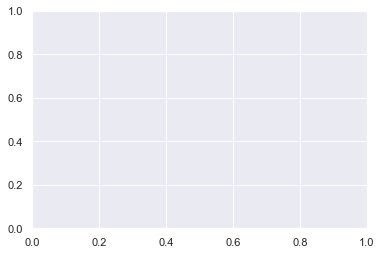

In [60]:
values =  np.array(values)
CS = plt.contourf(np.arange(-100,100,0.5), np.arange(-100,20,0.1), values.reshape(-1,80), levels=1000)
cbar = plt.colorbar()
cbar.set_label('Delta', rotation=270)
plt.xlabel('$ \mu_1$')
plt.ylabel('$ \sigma_1$')

In [121]:
def error(alpha, beta):
    X_1 = np.random.normal(0, 1, 100)
    X_2 =  np.random.normal(0, 1, 100)

    
    a_1 = alpha
    a_2 = -10
    b_1 = beta
    b_2 = 10
    Y_1 = a_1*X_1 + b_1 
    Y_2 = a_2*X_2 + b_2 

    X_ = np.concatenate((X_1, X_2))
    Y = np.concatenate((Y_1, Y_2))
    X = np.ones((200, 2))
    X[:,0] = X_
    params = (np.linalg.inv(X.T @ X)) @ (X.T @ Y)

    return (params[0] - ((a_1 + a_2) / 2)) ** 2 + (params[1] - ((b_1 + b_2) / 2)) **2

In [122]:
values = []
for mu in np.arange(-20,20,0.1):
    print(mu)
    x = []
    for sigma in np.arange(-20,20,0.1):
        x.append(error(mu,sigma))
    values.append(x)

-20.0
-19.9
-19.799999999999997
-19.699999999999996
-19.599999999999994
-19.499999999999993
-19.39999999999999
-19.29999999999999
-19.19999999999999
-19.099999999999987
-18.999999999999986
-18.899999999999984
-18.799999999999983
-18.69999999999998
-18.59999999999998
-18.49999999999998
-18.399999999999977
-18.299999999999976
-18.199999999999974
-18.099999999999973
-17.99999999999997
-17.89999999999997
-17.79999999999997
-17.699999999999967
-17.599999999999966
-17.499999999999964
-17.399999999999963
-17.29999999999996
-17.19999999999996
-17.09999999999996
-16.999999999999957
-16.899999999999956
-16.799999999999955
-16.699999999999953
-16.59999999999995
-16.49999999999995
-16.39999999999995
-16.299999999999947
-16.199999999999946
-16.099999999999945
-15.999999999999943
-15.899999999999942
-15.79999999999994
-15.699999999999939
-15.599999999999937
-15.499999999999936
-15.399999999999935
-15.299999999999933
-15.199999999999932
-15.09999999999993
-14.999999999999929
-14.899999999999928
-14.7

Text(0, 0.5, '$ \\beta_1 $')

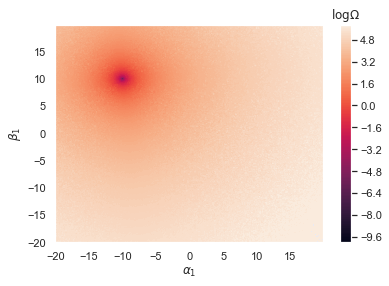

In [120]:
values_diff =  np.array(values)
CS = plt.contourf(np.arange(-20,20,0.1), np.arange(-20,20,0.1), np.log(values_diff.T),levels=np.arange(-10,6,0.1))
c = plt.colorbar()
c.ax.set_title('$ \log \Omega $', )
plt.xlabel(r'$ \alpha_1 $')
plt.ylabel(r'$ \beta_1 $')

Text(0, 0.5, '$ \\beta_1 $')

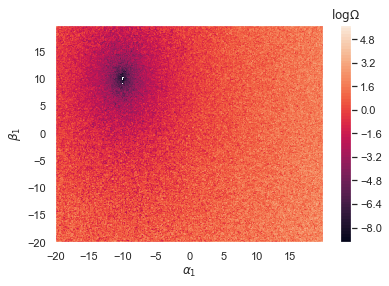

In [136]:
values = np.array(values)
CS = plt.contourf(np.arange(-20,20,0.1), np.arange(-20,20,0.1), np.log(values.T), levels=np.arange(-9,6,0.))
c = plt.colorbar()
c.ax.set_title('$ \log \Omega $', )
plt.xlabel(r'$ \alpha_1 $')
plt.ylabel(r'$ \beta_1 $')

/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '$ \\sigma_1 $')

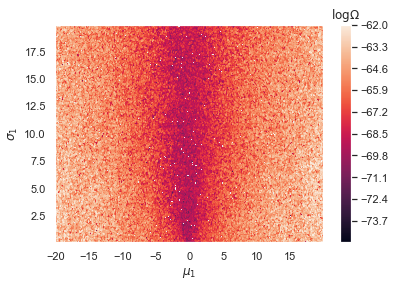

In [146]:
CS = plt.contourf(np.arange(-20,20,0.1), np.arange(0.1,20,0.1), np.log(values_sig.T), np.arange(-75,-62,0.01))
c = plt.colorbar()
c.ax.set_title('$ \log \Omega $', )
plt.xlabel(r'$ \mu_1 $')
plt.ylabel(r'$ \sigma_1 $')

TypeError: Length of y (199) must match number of rows in z (400)

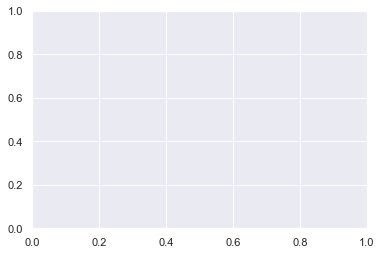

In [137]:
values_sig_diff =  np.array(values)
CS = plt.contourf(np.arange(-20,20,0.1), np.arange(0.1,20,0.1), (values_sig_diff.T))
c = plt.colorbar()
c.ax.set_title('$ \log \Omega $', )
plt.xlabel(r'$ \mu_1 $')
plt.ylabel(r'$ \sigma_1 $')

# Vary std

Text(0, 0.5, '$ \\Delta $')

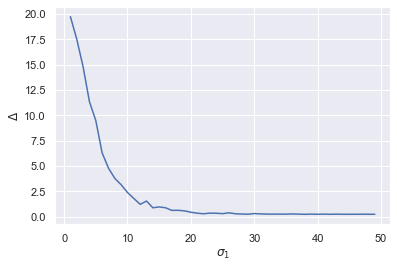

In [539]:
errors = np.vectorize(lambda x: error(10,x))(np.arange(1,50,1))
plt.plot(np.arange(1,50, 1), errors)
plt.xlabel('$\sigma_1$')
plt.ylabel('$ \Delta $')